## Random search compression on LeNet-5

In [13]:
import sys
sys.path.append('../')

In [14]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.rnd import RandomController, Individual
from utils.train import *
from utils.weight_sharing import *
from utils.plot import *
from utils.fitness_controller import FitnessController

Setting parameters 

In [15]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = '../models/lenet/saves/lenet_relu.save'
NET_TYPE = 'relu'

# random search iter count
NUM_INDIVIDUALS = 10

# random search search settings
REPR_RANGES = [range(1, 51) for _ in range(5)]

# random search save settings
SAVE_RND_FILE = '../results/test_RND_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = '../results/lenet-relu-layer-perf.csv'

# target position
TARGET = [1.0, 1.0]
LOCK_TARGET = False

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']
CLUST_MOD_FOCUS = None #[0, 0, 0, 0, 0]
CLUST_MOD_SPREAD = None #[0, 0, 0, 0, 0]

Geting somewhat trained LeNet-5

In [16]:
dataset = MnistDataset(BATCH_SIZE, '../data', val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [17]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.set_reset()

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [18]:
def fitness_vals_fc(individual):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    individual.data = ws_controller.share(individual.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, CLUST_MOD_FOCUS, CLUST_MOD_SPREAD)
    
    return [individual.data['accuracy'], individual.data['compression']]

def fit_from_vals(fit_vals, targ_vals, individual:Individual = None):

    result = None

    # compute fitness
    if fit_vals[0] <= 0.95:
        result = fit_vals[0]

    else:
        result = 1 / math.sqrt(pow(1 - ((fit_vals[0] - 0.9) * (1/0.1)), 2) + pow(1 - (fit_vals[1]/targ_vals[1]), 2))

    if individual is not None:
        individual.fitness = result
    
    return result

In [19]:
data = {
    'representation': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

rnd_data = pd.read_csv(SAVE_RND_FILE).astype(data_types) if os.path.exists(SAVE_RND_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(rnd_controler:RandomController):
    global rnd_data

    new_data = copy.deepcopy(data)

    indiv = rnd_controler.current_indiv

    new_data['representation'].append(indiv.representation)
    new_data['accuracy'].append(indiv.data['accuracy'])
    new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
    new_data['compression'].append(indiv.data['compression'])
    new_data['share_t'].append(indiv.data['times']['share'])
    new_data['train_t'].append(indiv.data['times']['train'])
    new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    rnd_data = rnd_data.append(pd.DataFrame(new_data).astype(data_types))
    rnd_data.reset_index(drop=True, inplace=True)
    os.makedirs(os.path.dirname(SAVE_RND_FILE), exist_ok=True)
    rnd_data.to_csv(SAVE_RND_FILE, index=False)

Setting ranges with optimization

In [20]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    REPR_RANGES = ws_controller.get_optimized_layer_ranges(REPR_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for repr_range in REPR_RANGES:
    print(len(repr_range))

49
47
47
48
47


Running the search

In [21]:
fit_controll = FitnessController(TARGET, fitness_vals_fc, fit_from_vals, target_max_offset=1, lock=LOCK_TARGET)
random = RandomController(REPR_RANGES, fit_controll)

if rnd_data.size != 0:
    random.load_from_pd(rnd_data, True)

random.run(NUM_INDIVIDUALS, logger_fc, verbose = True)

Fitness target update from load to [1.         9.34392643]
Individual 1/10 (10) evaluated Individual ([8, 31, 29, 47, 22]) fit:2.4825229146751084
Individual 2/10 (11) evaluated Individual ([28, 37, 29, 50, 26]) fit:1.9814777523240004
Individual 3/10 (12) evaluated Individual ([25, 28, 40, 39, 31]) fit:1.978967838028763
Individual 4/10 (13) evaluated Individual ([33, 44, 24, 36, 26]) fit:1.9475548194751633
Individual 5/10 (14) evaluated Individual ([31, 23, 43, 19, 20]) fit:2.0990146757099963
Individual 6/10 (15) evaluated Individual ([31, 38, 30, 27, 47]) fit:1.9664584861776924
Individual 7/10 (16) evaluated Individual ([26, 12, 38, 37, 32]) fit:2.141887919593268
Individual 8/10 (17) evaluated Individual ([11, 36, 48, 46, 29]) fit:2.070483213298684
Individual 9/10 (18) evaluated Individual ([11, 22, 7, 25, 29]) fit:2.964177903913412
Individual 10/10 (19) evaluated Individual ([45, 42, 11, 23, 5]) fit:2.6319302716224513


[8, 14, 49, 42, 6]

See output

In [22]:
rnd_data

,representation,accuracy,accuracy_loss,compression,share_t,train_t,acc_t,fitness
0,"[30, 27, 15, 26, 39]",0.9846,0.0000,5.373584,1.744936,0.0,5.385901,2.0
1,"[23, 34, 31, 46, 26]",0.9850,-0.0004,4.930540,1.531148,0.0,4.093654,2.0
2,"[8, 14, 49, 42, 6]",0.9820,0.0026,6.903546,1.847934,0.0,4.001732,3.0
3,"[37, 31, 8, 9, 20]",0.9840,0.0006,6.389330,0.909648,0.0,3.887888,2.0
4,"[22, 9, 42, 19, 22]",0.9838,0.0008,5.556952,1.627828,0.0,4.047384,2.0
5,"[22, 46, 16, 22, 36]",0.9844,0.0002,5.258833,1.013869,0.0,4.045885,2.0
6,"[6, 18, 37, 3, 11]",0.9698,0.0148,8.343926,2.066408,0.0,4.025748,3.0
7,"[6, 5, 10, 19, 18]",0.9762,0.0084,7.501463,0.763677,0.0,3.775530,3.0
8,"[48, 30, 44, 7, 12]",0.9842,0.0004,6.118467,1.793643,0.0,4.150927,2.0
9,"[11, 20, 21, 23, 37]",0.9854,-0.0008,5.538128,1.310089,0.0,3.839640,2.0


Plotting data

Text(0.5, 1.0, 'Random search on LeNet-5')

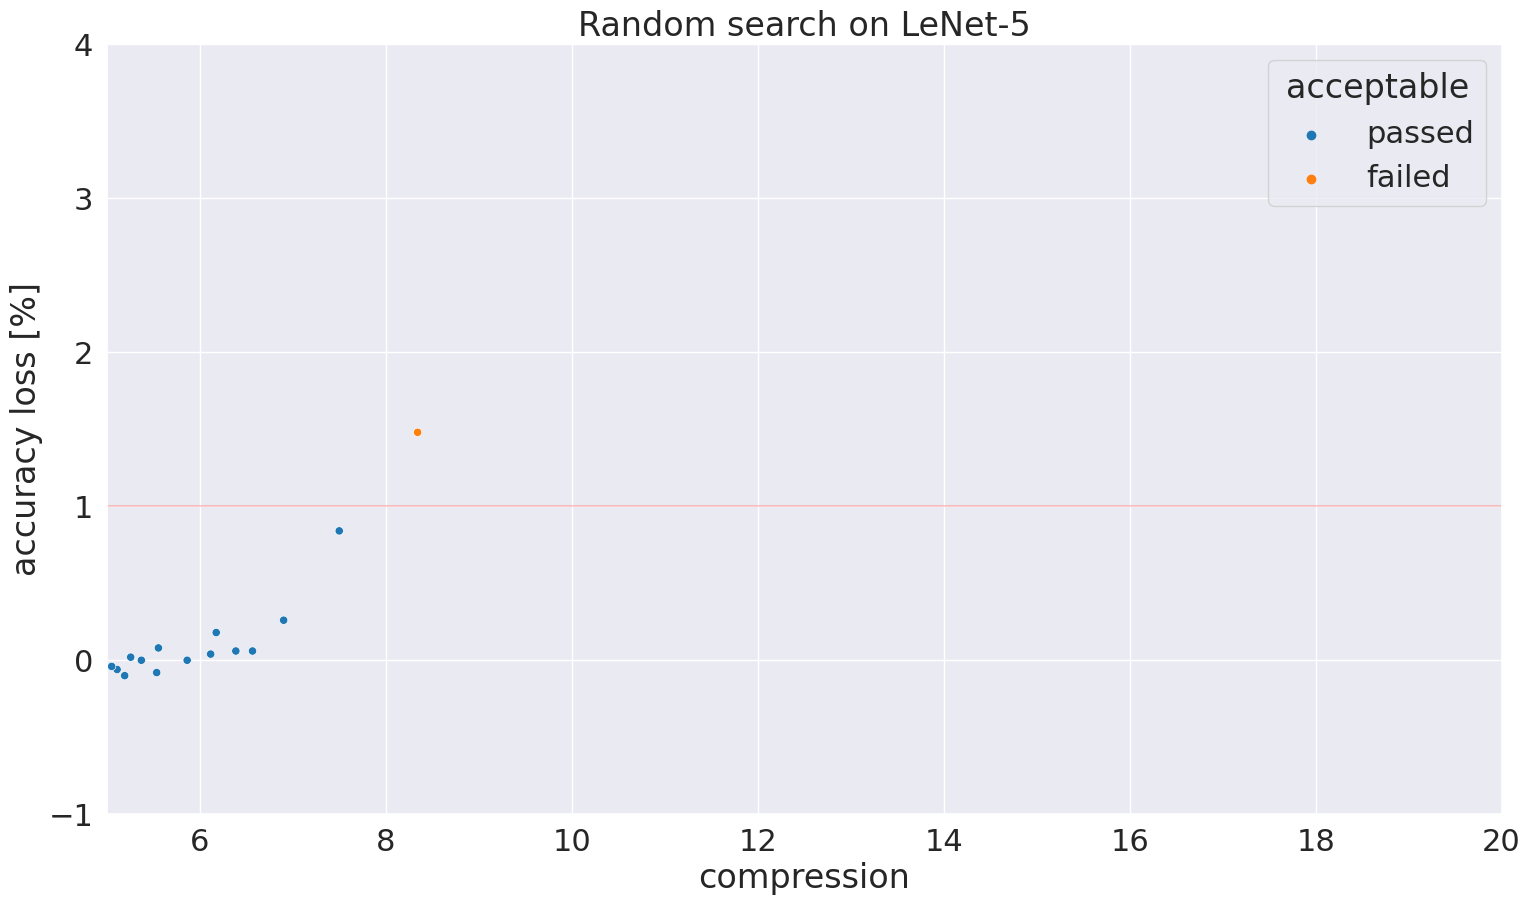

In [23]:
plot_alcr(rnd_data)
plt.title('Random search on LeNet-5')

In [24]:
fit_controll.targ

array([1.        , 9.34392643])